# Prosper Loan Data Exploration
## by Vilija Vaitkeviciute

## Preliminary Wrangling

The loan data from [Prosper](https://www.prosper.com/), an online lending platform that connects people who want to borrow money with individuals and institutions, is explored here.  The loan data includes loan characteristics, Prosper's internal tracking data, borrower profile and some lender information.

The analysis will focus on
- understanding how the lender's estimated return relates to various factors, and 
- relationship between expected losses and actual losses. 

The first question is of interest for potential lenders, who may not be familiar with loan pricing mechanism, or even for auditors and competitors, while the second question is a proxy for how a return estimate relates to actual returns.  The latter is a proxy because losses are one part of return (the other part being yield and other fees).  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# load dataset
df = pd.read_csv('prosperLoanData.csv')
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [3]:
df.shape

(113937, 81)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
ListingKey                             113937 non-null object
ListingNumber                          113937 non-null int64
ListingCreationDate                    113937 non-null object
CreditGrade                            28953 non-null object
Term                                   113937 non-null int64
LoanStatus                             113937 non-null object
ClosedDate                             55089 non-null object
BorrowerAPR                            113912 non-null float64
BorrowerRate                           113937 non-null float64
LenderYield                            113937 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating (numeric)                84853 non-null float64
ProsperRating (Alpha) 

In [29]:
#converting all dates to datetime
df.ListingCreationDate = pd.to_datetime(df.ListingCreationDate)
df.LoanOriginationDate = pd.to_datetime(df.LoanOriginationDate)
df.DateCreditPulled = pd.to_datetime(df.DateCreditPulled)
df.ClosedDate = pd.to_datetime(df.ClosedDate)

Variable dictionary mentions a change in loan data applicable for loans originated after July 2009; this includes calculations of Effective Yield, Estimated Loss and Effective Return, key variables analysed.  Therefore, I will drop the loan listings that occure before July 2009.  Before doing this, I will check the loan listing distribution accross time, to ensure there will be sufficient remaining data for the proposed analysis.

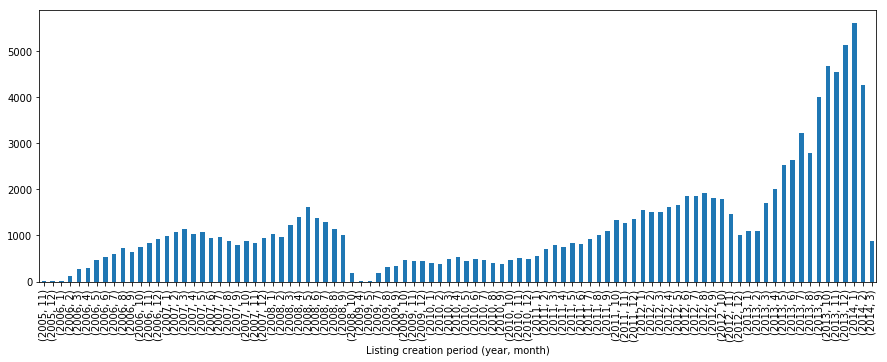

In [25]:
plt.figure(figsize=[15,5])
df.groupby([df.ListingCreationDate.dt.year,df.ListingCreationDate.dt.month])['ListingCreationDate'].count().plot(kind='bar')
plt.xlabel('Listing creation period (year, month)');

There appears to be sufficient data for analysis for post July 2009 period.  Will drop earlier observations (in line when first EstimatedReturn is recorded).

In [30]:
min_date = min(df[~df.EstimatedReturn.isnull()].ListingCreationDate)
min_date

Timestamp('2009-07-13 18:01:24.347000')

In [31]:
df = df[df.ListingCreationDate>= min_date]
df.shape

(84853, 81)

As the dataset contains 81 variables, I will create a correlation matrix for the numeric variables, in order to make a preliminary decision as to which set of variables are likely to relate to variables of interest.

This will not be conclusive analysis, because, among others:
- linear correlation is not the only type of relashionship, 
- this excludes any categorical variables,
- in cases where relationship between variables is expected, but corr. coefficient is low, it is interesting to dig further.

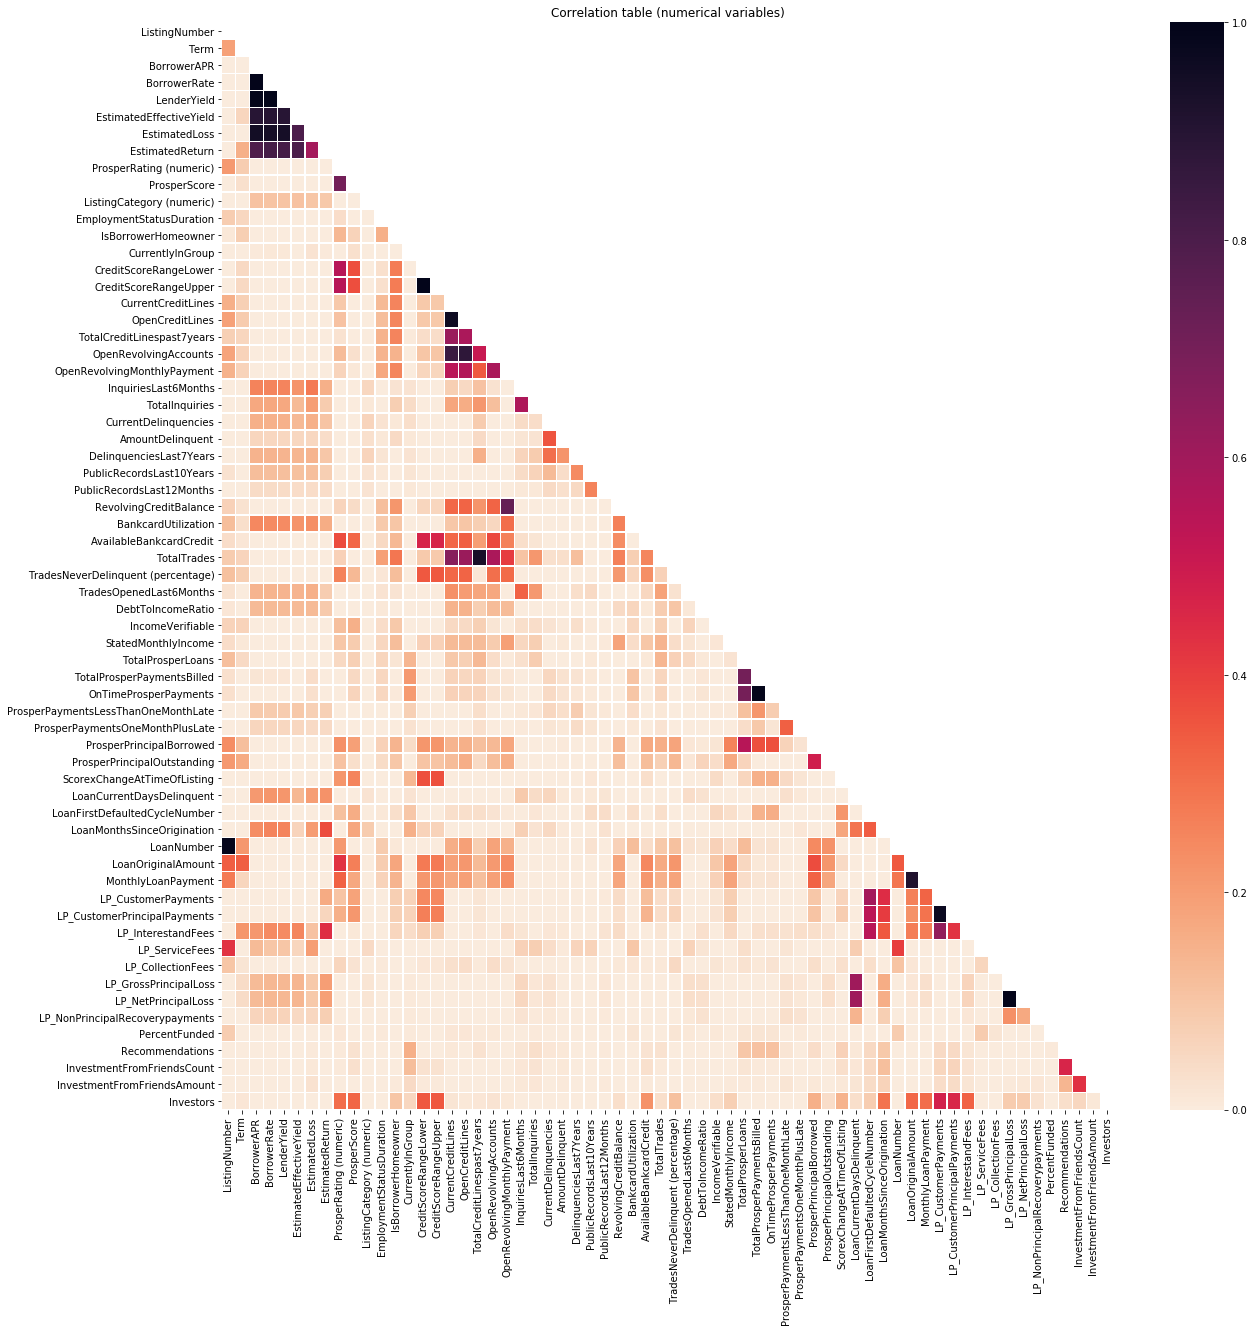

In [27]:
#lets check correlations of all numeric variables
plt.figure(figsize=[20,20])

#compute correlations
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot heatmap
sns.heatmap(corr, cmap = 'rocket_r', vmin = 0, mask=mask, linewidths=0.5)
plt.title('Correlation table (numerical variables)');

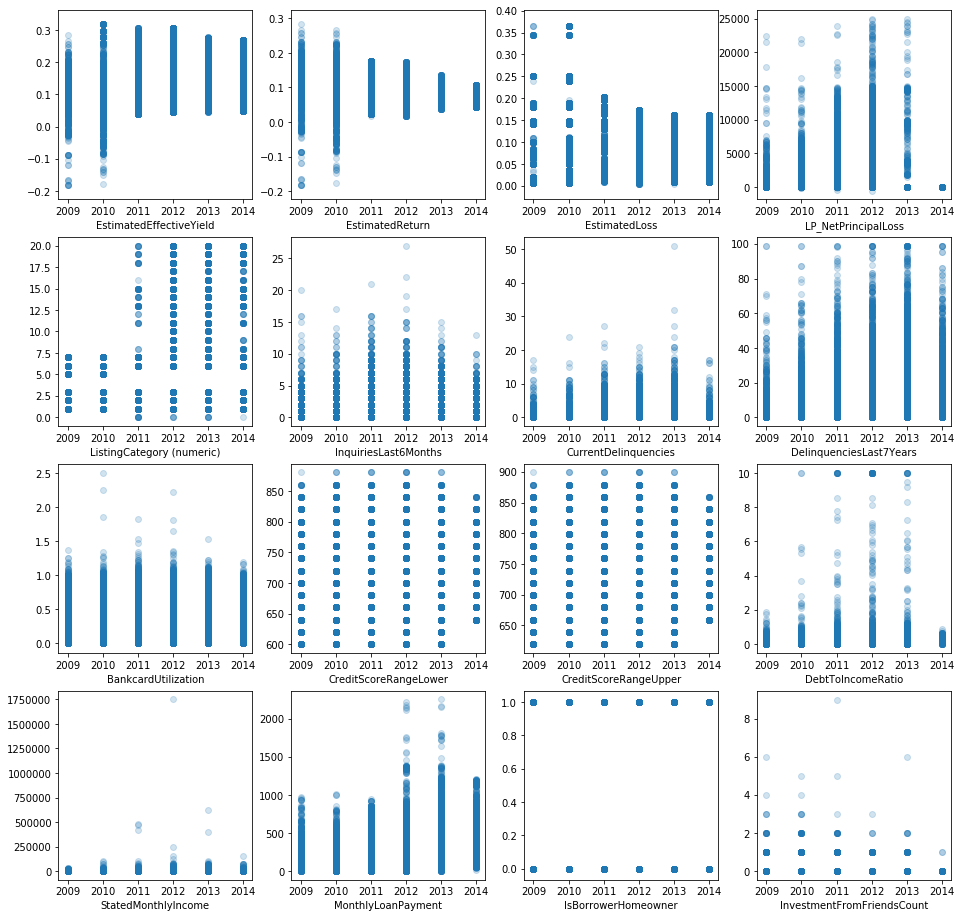

In [28]:
columns = 4
rows = 4

fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize = [16,16])

variables = ['EstimatedEffectiveYield', 'EstimatedReturn', 'EstimatedLoss', 'LP_NetPrincipalLoss',
             'ListingCategory (numeric)', 'InquiriesLast6Months', 'CurrentDelinquencies', 'DelinquenciesLast7Years',
             'BankcardUtilization',  'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'DebtToIncomeRatio',
             'StatedMonthlyIncome', 'MonthlyLoanPayment', 'IsBorrowerHomeowner', 'InvestmentFromFriendsCount']

for i in range(rows):
    for j in range(columns):
        var = variables[j+i*columns]
        ax[i,j].scatter(x = df.ListingCreationDate.dt.year, y = df[var], alpha = 0.2)
        ax[i,j].set_xlabel('{}'.format(var))
    
plt.show()

### What is the structure of your dataset?

There are 84,853 observations in the dataset (abreviated to include only post 13-July-2009 observations), where 13-July-2009 marks introduction of EstimatedReturn, EstimatedLoss, Estimated Yield, ProsperScore and other key variables to the analysis.

The dataset contains 81 features, of which majority are numerical (61), categorical (17) and boolean (3); some of the numerical variables are numerical categories or ratings (such as 'ProsperRating (numeric)', ListingCategory, ProsperScore). 

### What is/are the main feature(s) of interest in your dataset?

The analysis will focus on
- understanding how the lender's estimated return relates to various factors, and 
- relationship between expected losses and actual losses. 

The first question is of interest for potential lenders, who may not be familiar with loan pricing mechanism, or even for auditors and competitors, while the second question is a proxy for how a return estimate relates to actual returns.  The latter is a proxy because losses are one part of return (the other part being yield and other fees).  

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

#### Linearly correlated variables:
The following are numerical variables that have higher correlation coefficients with estimated lender return (EstimatedReturn) and actual principal loss (LP_NetPrincipalLoss):
> 'EstimatedEffectiveYield', 'EstimatedLoss', 'LP_NetPrincipalLoss', 'ListingCategory (numeric)', 'InquiriesLast6Months', 'CurrentDelinquencies', 'DelinquenciesLast7Years', 'BankcardUtilization',  'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'DebtToIncomeRatio', 'StatedMonthlyIncome', 'MonthlyLoanPayment', 'IsBorrowerHomeowner', 'InvestmentFromFriendsCount'

These variables can be categorised as follows:
- EstimatedReturn components (estimates/actuals) ('EstimatedEffectiveYield', 'EstimatedLoss', 'LP_NetPrincipalLoss'),
- borrower's current and historical need/utisation of credit facilities ('InquiriesLast6Months', 'CurrentDelinquencies', 'DelinquenciesLast7Years', 'BankcardUtilization'),
- borrower's credit score as provided by external agencies ('CreditScoreRangeLower', 'CreditScoreRangeUpper'),
- borrower's income profile ('DebtToIncomeRatio', 'StatedMonthlyIncome', 'MonthlyLoanPayment', 'IsBorrowerHomeowner'),
- loan's properties ('ListingCategory (numeric)', 'InvestmentFromFriendsCount') 

##### Except:
Few variables, that are highly correlated such as BorrowerRate, BorrowerAPR are excluded, as they are expected to be linear to EstimatedReturns (e.g. in this case, difference is Prosper's margin).

#### Further variables
Additional variables (non numerical) to be included in analysis:
- date variables for time trends analysis, which in any, especially financial data is of importance ('ListingCreationDate', 'ClosedDate', 'LoanOriginationDate')
- categorical variables, which were not included in correlation analysis ('Occupation')
- variables that will need to be transformed, e.g because being abslute variables, could not have produced linear correlation with EstimatedReturns (e.g. 'InvestmentFromFriendsAmount' in calculating % of loan lent by friends, 'LoanOriginalAmount' in calculating % loan loss)

## Univariate Exploration

### EstimatedReturn components (estimates)

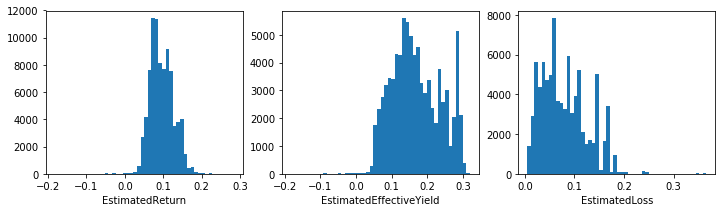

In [107]:
columns = 3
fig, ax = plt.subplots(ncols=columns, figsize = [12,3])
variables = ['EstimatedReturn', 'EstimatedEffectiveYield', 'EstimatedLoss']

for j in range(columns):
    var = variables[j]
    ax[j].hist(df[var], bins=50)
    ax[j].set_xlabel('{}'.format(var))
    
plt.show()

In [60]:
df[df.EstimatedReturn < 0]['ListingKey'].count(), df[df.EstimatedEffectiveYield < 0]['ListingKey'].count()

(195, 190)

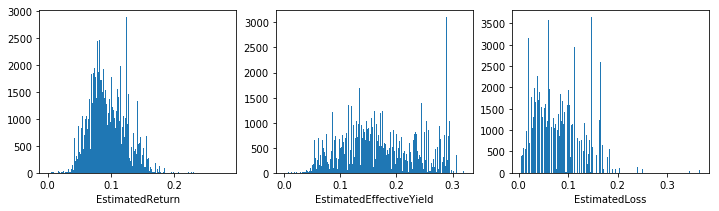

In [108]:
columns = 3
fig, ax = plt.subplots(ncols=columns, figsize = [12,3])
variables = ['EstimatedReturn', 'EstimatedEffectiveYield', 'EstimatedLoss']

for j in range(columns):
    var = variables[j]
    ax[j].hist(df[var][df[var]>0], bins=200)
    ax[j].set_xlabel('{}'.format(var))
    
plt.show()

### Loss (estimated/actual)

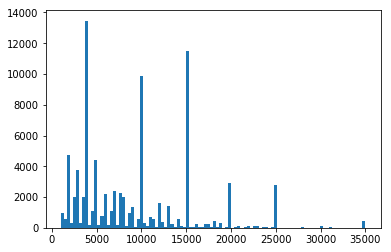

In [68]:
plt.hist(df.LoanOriginalAmount, bins=100);

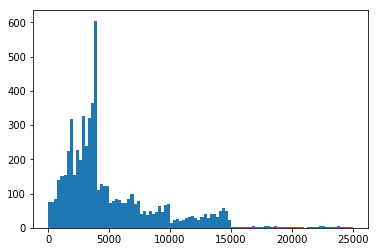

In [71]:
plt.hist(df.LP_NetPrincipalLoss[df.LP_NetPrincipalLoss > 0], bins=100);

In [88]:
df['LoanLossRatio'] = df.LP_NetPrincipalLoss/df.LoanOriginalAmount

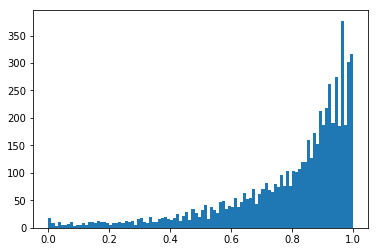

In [90]:
plt.hist(df.LoanLossRatio[(df.LoanLossRatio > 0)], bins=100);

### Borrower's current and historical need/utisation of credit facilities

'InquiriesLast6Months', 'CurrentDelinquencies', 'DelinquenciesLast7Years', 'BankcardUtilization'

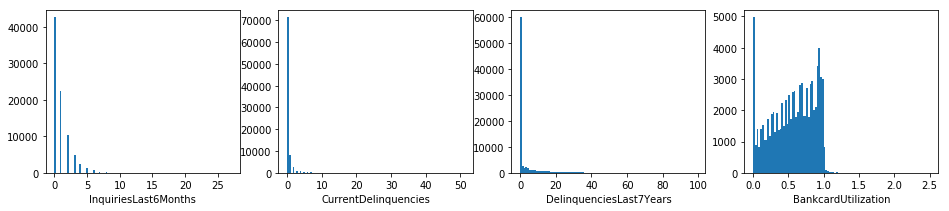

In [106]:
columns = 4
fig, ax = plt.subplots(ncols=columns, figsize = [16,3])
variables = ['InquiriesLast6Months', 'CurrentDelinquencies', 'DelinquenciesLast7Years', 'BankcardUtilization']

for j in range(columns):
    var = variables[j]
    ax[j].hist(df[var], bins=100)
    ax[j].set_xlabel('{}'.format(var))
    
plt.show()

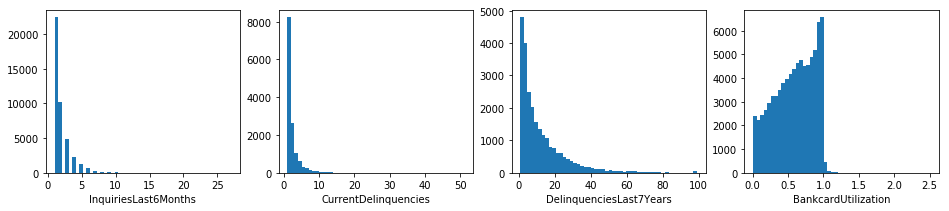

In [114]:
columns = 4
fig, ax = plt.subplots(ncols=columns, figsize = [16,3])
variables = ['InquiriesLast6Months', 'CurrentDelinquencies', 'DelinquenciesLast7Years', 'BankcardUtilization']

for j in range(columns):
    var = variables[j]
    ax[j].hist(df[var][(df[var] > 0)], bins=50)
    ax[j].set_xlabel('{}'.format(var))
    
plt.show()

### Borrower's credit score as provided by external agencies 
'CreditScoreRangeLower', 'CreditScoreRangeUpper'

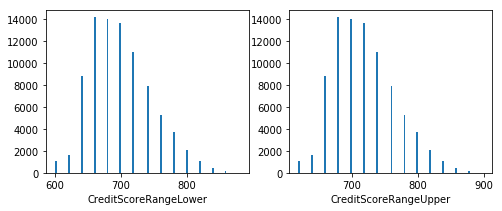

In [117]:
columns = 2
fig, ax = plt.subplots(ncols=columns, figsize = [8,3])

variables = ['CreditScoreRangeLower', 'CreditScoreRangeUpper']

for j in range(columns):
    var = variables[j]
    ax[j].hist(df[var], bins=100)
    ax[j].set_xlabel('{}'.format(var))
    
plt.show()

### Borrower's income profile
'DebtToIncomeRatio', 'StatedMonthlyIncome', 'MonthlyLoanPayment', 'IsBorrowerHomeowner'

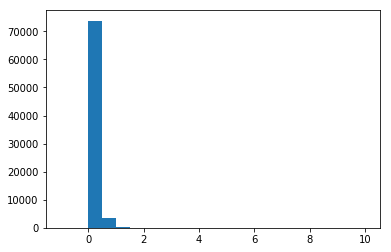

In [132]:
bins = np.arange(-1,max(df.DebtToIncomeRatio),0.5)
plt.hist(df.DebtToIncomeRatio, bins=bins);

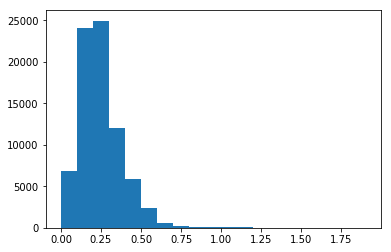

In [134]:
bins = np.arange(0,2,0.1)
plt.hist(df.DebtToIncomeRatio, bins=bins);

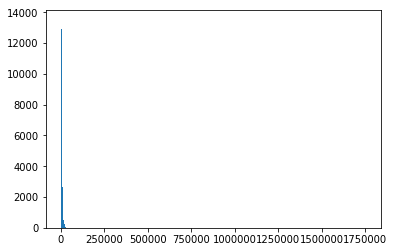

In [135]:
bins = np.arange(-1,max(df.StatedMonthlyIncome),1000)
plt.hist(df.StatedMonthlyIncome, bins=bins);

In [140]:
df.StatedMonthlyIncome[df.StatedMonthlyIncome > 50000].count()

61

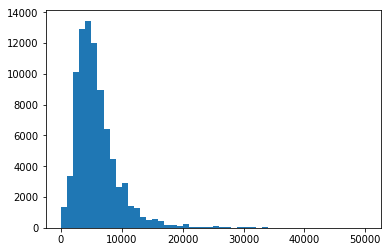

In [141]:
bins = np.arange(-1,50000,1000)
plt.hist(df.StatedMonthlyIncome, bins=bins);

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!